## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
def camera_cali():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imshow('img',img) # this will a window showing the images with corners drawed
            #cv2.waitKey(100)

    #cv2.destroyAllWindows()
    return objpoints, imgpoints

objpoints, imgpoints = camera_cali()

## Apply the camera calibration given objpoints and image points

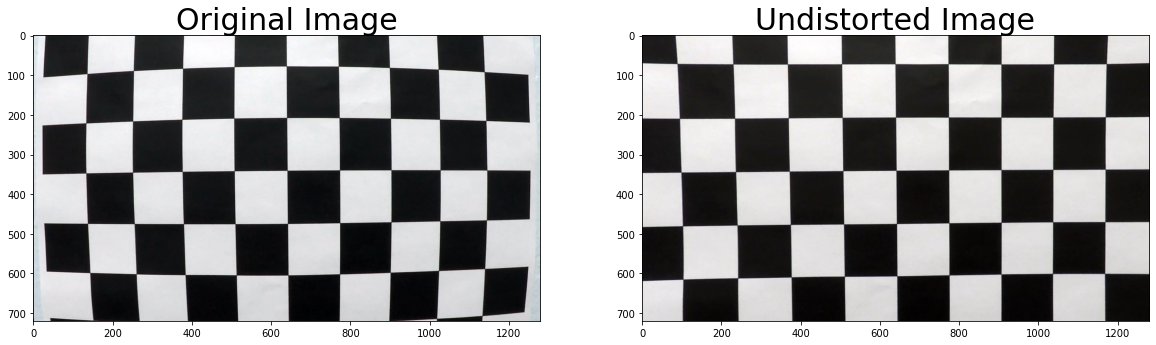

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('../camera_cal/calibration1.jpg')

def undistort(img,objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('../output_images/camera_cal_out.jpg',dst)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "../output_images/wide_dist_pickle.p", "wb" ) )
    return img,dst

img,dst = undistort(img,objpoints, imgpoints)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('image1.jpg')


In [3]:
## Use color transforms, gradients, etc., to create a thresholded binary image.

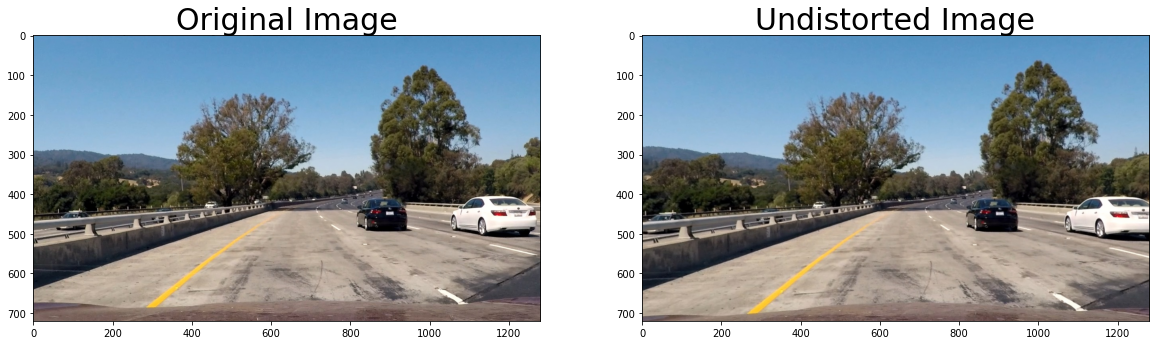

In [4]:


img = cv2.imread('../test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('../output_images/test1_out.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
#pickle.dump( dist_pickle, open( "../output_images/test1_wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('image2.jpg')


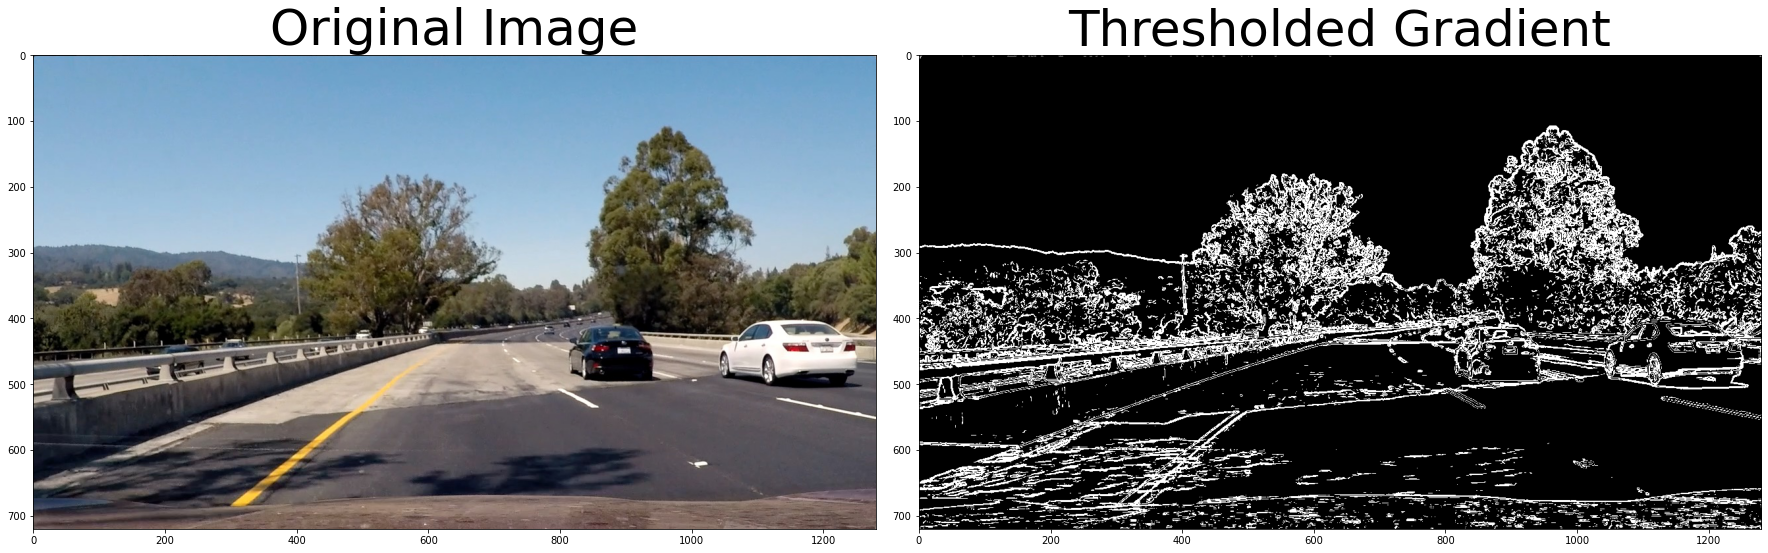

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle



# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output


# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Read in an image and grayscale it
image = mpimg.imread('../test_images/test4.jpg')
ksize = 3
# Run the function
grad_binary = mag_thresh(image, sobel_kernel=ksize, thresh=(20,100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('image3.jpg')



In [6]:
# Choose a Sobel kernel size

def thresh_image(image,ksize=3,threshx=(0,255),threshy=(0,255),thresh_mag=(50, 200)):
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=threshx)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=threshy)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=thresh_mag)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return image,mag_binary


"""
image,mag_binary = thresh_image(img,ksize=3,threshx=(0,255),threshy=(0,255),thresh_mag=(50, 200))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
"""


"\nimage,mag_binary = thresh_image(img,ksize=3,threshx=(0,255),threshy=(0,255),thresh_mag=(50, 200))\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(image)\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(mag_binary, cmap='gray')\nax2.set_title('Thresholded Gradient', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n"

In [7]:
## Perspective Transformation


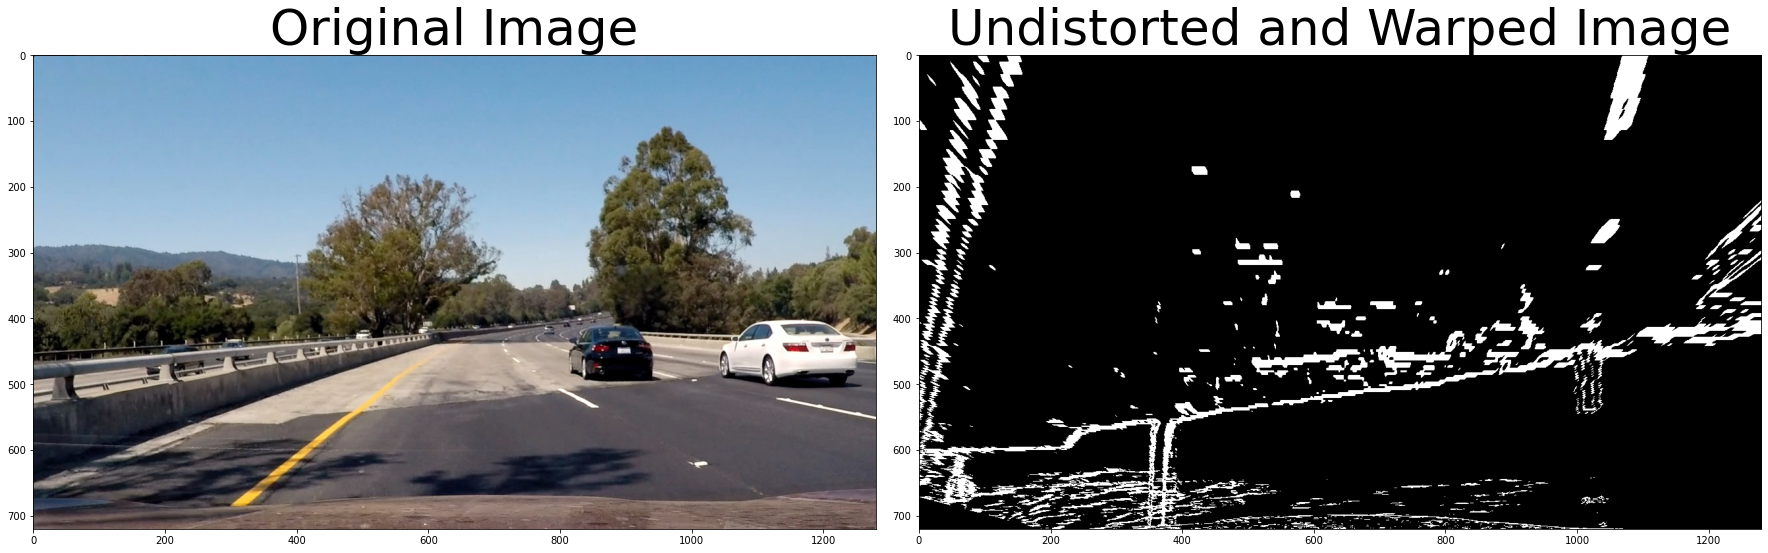

In [8]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    # gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    gray = img
    # Search for corners in the grayscaled image
    #ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    ret = 1

    if ret == True:
        
        # If we found corners, draw them! (just for fun)
        # cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        """
        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
                                     
        """
        
        src = np.float32(
            [[(img_size[0] / 2) - 63, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 20), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
        dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])
        
        #print("src=\n",src)
        
        #print("dst=\n",dst)
        
      
        
        """
        src = np.float32(
            [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 10), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
        dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])
            
        """
        

        
        
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        # print("M is",M)
        # Warp the image using OpenCV warpPerspective()
        
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv




# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load(open( "./wide_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
#print("mtx,dist",mtx,dist)

# Read in an image
# img = cv2.imread('../test_images/test_image2.png')
# img = cv2.imread('../test_images/straight_lines1.jpg')


top_down, perspective_M, Minv = corners_unwarp(grad_binary, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
#img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down,cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('image4.jpg')

In [9]:


## locate the lane lines

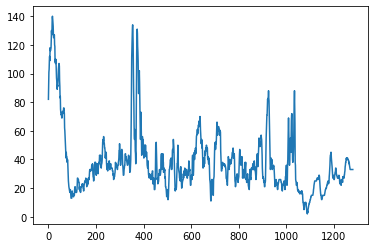

In [10]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
# img = mpimg.imread('warped_example.jpg')/255

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = None
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = None
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(top_down)

# Visualize the resulting histogram
plt.plot(histogram)

In [11]:

import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
# binary_warped = mpimg.imread('warped_example.jpg')
# binary_warped = top_down
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # plt.imshow(out_img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(histogram.shape[0]//2)
    fourthpoint = midpoint//2
    # print("histogram[fourthpoint:midpoint] is\n",histogram[fourthpoint:midpoint])
    leftx_base = np.argmax(histogram[fourthpoint:midpoint]) + fourthpoint
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #print("leftx_base is\n",leftx_base)
    #print("rightx_base is\n",rightx_base)

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 18
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 500

    # Set height of windows - based on nwindows above and image shape
    window_height = int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    # print("nonezero is\n",nonzero)
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    leftx,lefty,rightx,righty = [],[],[],[]

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        # left_lane_inds.append(good_left_inds)
        # right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        
        # print("len(good_left_inds) > minpix",len(good_left_inds),minpix)
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
            left_lane_inds.append(good_left_inds)
            
            #print("left found")
        else:
            pass
            #print("left not found",left_lane_inds[-1])
            #left_lane_inds.append(left_lane_inds[-1])
        leftx.append(leftx_current)
        lefty.append(win_y_low)
        
            
            
        # print("len(good_right_inds) > minpix",len(good_right_inds),minpix)
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))
            right_lane_inds.append(good_right_inds)
            # print("right found")
        else:
            pass
            # print("right not found",right_lane_inds[-1])
            # right_lane_inds.append(right_lane_inds[-1])
            
        rightx.append(rightx_current)
        righty.append(win_y_low)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    
    """    
    leftx  = nonzerox[left_lane_inds]
    lefty  = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    """

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    # plt.imshow(out_img)
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    # plt.plot(left_fitx, ploty, color='yellow')
    # plt.plot(right_fitx, ploty, color='yellow')

    return out_img,ploty,left_fitx, right_fitx,left_fit, right_fit


out_img,ploty,left_fitx, right_fitx,left_fit, right_fit = fit_polynomial(top_down)

# plt.imshow(top_down)
# plt.imshow(out_img)
# plt.savefig('image5.jpg')


"""f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(out_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down,cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.savefig('image4.jpg')"""




#img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([  88,   89,   90, ..., 1066, 1067, 1068]))


"f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(out_img)\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(top_down,cmap='gray')\nax2.set_title('Undistorted and Warped Image', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n#plt.savefig('image4.jpg')"

In [12]:
# calculate the curvature


In [13]:
def measure_curvature_pixels(ploty,left_fit, right_fit, ym_per_pix=30/720, xm_per_pix=3.7/700):
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    
   

    y_eval = np.max(ploty)*ym_per_pix
    print("y_eval is",y_eval)
    #print("left_fit\n",left_fit)
    #print("right_fit\n",right_fit)
    # print("the car position respect to center of the two line is",(left_fit[0]+right_fit[1])/2 - binary_warped.shape[1]/2)
    left_a_new = xm_per_pix/(ym_per_pix**2)*left_fit[0]
    left_b_new = xm_per_pix/(ym_per_pix)*left_fit[1]
    right_a_new = xm_per_pix/(ym_per_pix**2)*right_fit[0]
    right_b_new = xm_per_pix/(ym_per_pix)*right_fit[1]
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_a_new*y_eval + left_b_new)**2)**1.5) / np.absolute(2*left_a_new)
    right_curverad = ((1 + (2*right_a_new*y_eval + right_b_new)**2)**1.5) / np.absolute(2*right_a_new)
    
    return left_curverad, right_curverad
    
def measure_offset(img,left_fitx, right_fitx,ym_per_pix=30/720, xm_per_pix=3.7/700):
    if (len(right_fitx)>0 and len(left_fitx)>0):
        pix_off = (right_fitx[0] - left_fitx[0])/2 - img.shape[1]/2
        dis_off = pix_off *  xm_per_pix
    else:
        dis_off = 0
        
    return dis_off
    
    

In [14]:
# Define conversions in x and y from pixels space to meters
#ym_per_pix = 30/720 # meters per pixel in y dimension
#xm_per_pix = 3.7/700 # meters per pixel in x dimension
#left_curverad, right_curverad = measure_curvature_pixels(ploty,left_fitx, right_fitx, ym_per_pix=ym_per_pix, xm_per_pix=xm_per_pix)

#print(left_curverad, right_curverad)

In [15]:
def add_curve_on_pic(image, left_curverad, right_curverad, offset, color=(255,0,0)):
    direction = "right" if offset < 0 else "left"
    str_left_curve = "left curverad = {}(m)".format(int(left_curverad))
    str_right_curve = "right curverad = {}(m)".format(int(right_curverad))
    
    str_offset = "Car is {0:.2f}m ".format(abs(offset)) + "{} away off center".format(direction)
    cv2.putText(image, str_left_curve, (50,60), cv2.FONT_HERSHEY_SIMPLEX,2,color,2)
    cv2.putText(image, str_right_curve, (50,120), cv2.FONT_HERSHEY_SIMPLEX,2,color,2)
    cv2.putText(image, str_offset, (50,180), cv2.FONT_HERSHEY_SIMPLEX,2,color,2)
    
    
    

In [16]:


# transform back to real world curvature

In [17]:
## plot area between the lane back to the image

In [18]:
def draw_lane_fit(undist, warped ,Minv, left_fitx, right_fitx, ploty):
    # Drawing
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix(Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    #print("newwarp",newwarp.shape[0],newwarp.shape[1],newwarp.shape[2])
    #print("undist",undist.shape[0],undist.shape[1],newwarp.shape[2])
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

#exampleImg_out1 = project_fit_lane_info(img, binary_warped, left_fitx, right_fitx, Minv)
#plt.imshow(exampleImg_out1)
#left_fitx, right_fitx
# print("Minv=\n",Minv)



#result = draw_lane_fit(img,top_down,Minv,left_fitx, right_fitx, ploty)
#plt.imshow(result)
#plt.savefig('image6.jpg')

In [19]:
def pipeline(img):
    objpoints, imgpoints = camera_cali() # calibrate the camera 
       
    img,dst = undistort(img,objpoints, imgpoints) # apply the calibration on img
        
    img,mag_binary = thresh_image(img,ksize=3,threshx=(0,255),threshy=(0,255),thresh_mag=(50, 200))
    # img is the original image, mag_binary is the magnitude of x_derivative and y_derivative
    
    # Read in the saved camera matrix and distortion coefficients
    # These are the arrays you calculated using cv2.calibrateCamera()
    dist_pickle = pickle.load(open("./wide_dist_pickle.p", "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    top_down, perspective_M, Minv = corners_unwarp(mag_binary, mtx, dist)

    out_img,ploty,left_fitx, right_fitx ,left_fit, right_fit = fit_polynomial(top_down)
    
    left_curverad, right_curverad = measure_curvature_pixels(ploty,left_fit, right_fit)
    
    print("left_curverad, right_curverad",left_curverad, right_curverad)
    offset = measure_offset(img,left_fitx, right_fitx)
    print("offset is",offset)
    add_curve_on_pic(img, left_curverad, right_curverad, offset, color=(0,255,255))
    
    result = draw_lane_fit(img,top_down,Minv,left_fitx, right_fitx, ploty)
    
    #plt.imshow(result)
    
    #plt.savefig('image_pitfall.jpg')
    
    return result

img.shape[0] 720
nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([   8,    9,   10, ..., 1037, 1038, 1039]))
y_eval is 29.958333333333332
left_curverad, right_curverad 995.237171440484 538.7141605839726
offset is -1.8054887218045117


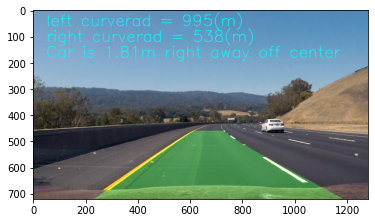

In [20]:
#img = cv2.imread('../camera_cal/calibration1.jpg')
img = mpimg.imread('../test_images/test3.jpg')
print("img.shape[0]",img.shape[0])

result = pipeline(img)
plt.imshow(result)
plt.savefig('image_pitfall.jpg')

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [22]:
def process_image(image):
    return pipeline(image)

In [ ]:
white_output = '../project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,1)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([   0,    1,    2, ..., 1040, 1041, 1042]))
y_eval is 29.958333333333332
left_curverad, right_curverad 800.2316298047524 520.7466472428664
offset is -1.7677932330827066
Moviepy - Building video ../project_video_out.mp4.
Moviepy - Writing video ../project_video_out.mp4



t:   0%|          | 2/1260 [00:02<23:05,  1.10s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([   0,    1,    2, ..., 1040, 1041, 1042]))
y_eval is 29.958333333333332
left_curverad, right_curverad 800.2316298047524 520.7466472428664
offset is -1.7677932330827066


t:   0%|          | 3/1260 [00:04<33:44,  1.61s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 268,  269,  270, ..., 1044, 1045, 1046]))
y_eval is 29.958333333333332
left_curverad, right_curverad 497.74004281041573 469.7323233619801
offset is -1.7544630325814543


t:   0%|          | 4/1260 [00:06<38:28,  1.84s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 268,  269,  270, ..., 1044, 1045, 1046]))
y_eval is 29.958333333333332
left_curverad, right_curverad 544.8828572675206 357.20223997630336
offset is -1.8192130325814537


t:   0%|          | 5/1260 [00:08<41:05,  1.96s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 268,  269,  270, ..., 1018, 1019, 1020]))
y_eval is 29.958333333333332
left_curverad, right_curverad 547.058275266358 610.1556736451641
offset is -1.7864786967418556


t:   0%|          | 6/1260 [00:11<43:00,  2.06s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 263,  264,  265, ..., 1048, 1049, 1050]))
y_eval is 29.958333333333332
left_curverad, right_curverad 790.2807295653276 487.2362977711014
offset is -1.8275820802005007


t:   1%|          | 7/1260 [00:13<44:04,  2.11s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 263,  264,  265, ..., 1048, 1049, 1050]))
y_eval is 29.958333333333332
left_curverad, right_curverad 745.318818707338 436.6273640877245
offset is -1.8383621553884713


t:   1%|          | 8/1260 [00:15<44:24,  2.13s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 263,  264,  265, ..., 1048, 1049, 1050]))
y_eval is 29.958333333333332
left_curverad, right_curverad 823.0048782859626 541.0473141618417
offset is -1.815503759398496


t:   1%|          | 9/1260 [00:17<44:47,  2.15s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 263,  264,  265, ..., 1022, 1023, 1024]))
y_eval is 29.958333333333332
left_curverad, right_curverad 837.7290042813416 526.8246461155029
offset is -1.8177525062656648


t:   1%|          | 10/1260 [00:20<45:28,  2.18s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 258,  259,  260, ..., 1042, 1043, 1044]))
y_eval is 29.958333333333332
left_curverad, right_curverad 554.225262068939 478.5807158407305
offset is -1.7742844611528825


t:   1%|          | 11/1260 [00:22<45:56,  2.21s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 253,  254,  255, ..., 1021, 1022, 1023]))
y_eval is 29.958333333333332
left_curverad, right_curverad 560.7718907158795 546.1373223343155
offset is -1.7670281954887221


t:   1%|          | 12/1260 [00:24<46:08,  2.22s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 258,  259,  260, ..., 1015, 1016, 1017]))
y_eval is 29.958333333333332
left_curverad, right_curverad 581.2271063774593 361.0412333020843
offset is -1.8198853383458649


t:   1%|          | 13/1260 [00:26<46:10,  2.22s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 248,  249,  250, ..., 1047, 1048, 1049]))
y_eval is 29.958333333333332
left_curverad, right_curverad 587.498835202992 740.7265503573223
offset is -1.700585839598997


t:   1%|          | 14/1260 [00:29<46:19,  2.23s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 248,  249,  250, ..., 1022, 1046, 1047]))
y_eval is 29.958333333333332
left_curverad, right_curverad 613.6695603180698 437.5250250656064
offset is -1.7488295739348365


t:   1%|          | 15/1260 [00:31<45:59,  2.22s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 248,  249,  250, ..., 1047, 1048, 1049]))
y_eval is 29.958333333333332
left_curverad, right_curverad 614.0401016742711 558.3401842194991
offset is -1.749803258145363


t:   1%|▏         | 16/1260 [00:33<45:33,  2.20s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 253,  254,  255, ..., 1049, 1050, 1051]))
y_eval is 29.958333333333332
left_curverad, right_curverad 644.4338942866169 437.4089917619899
offset is -1.840518170426065


t:   1%|▏         | 17/1260 [00:35<45:08,  2.18s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 253,  254,  255, ..., 1017, 1046, 1047]))
y_eval is 29.958333333333332
left_curverad, right_curverad 719.9030553610546 597.7214826101708
offset is -1.8813201754385969


t:   1%|▏         | 18/1260 [00:37<44:59,  2.17s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 253,  254,  255, ..., 1045, 1046, 1047]))
y_eval is 29.958333333333332
left_curverad, right_curverad 663.0979178785069 588.6723204429754
offset is -1.8749680451127817


t:   2%|▏         | 19/1260 [00:39<45:25,  2.20s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 253,  254,  255, ..., 1041, 1046, 1047]))
y_eval is 29.958333333333332
left_curverad, right_curverad 663.3164846294568 364.90200387732796
offset is -1.8696359649122807


t:   2%|▏         | 20/1260 [00:42<45:42,  2.21s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 248,  249,  250, ..., 1041, 1042, 1043]))
y_eval is 29.958333333333332
left_curverad, right_curverad 725.9364238969256 613.6332699056796
offset is -1.8544743107769421


t:   2%|▏         | 21/1260 [00:44<45:55,  2.22s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 248,  249,  250, ..., 1042, 1043, 1044]))
y_eval is 29.958333333333332
left_curverad, right_curverad 769.0963235486195 359.9616972391708
offset is -1.831523182957394


t:   2%|▏         | 22/1260 [00:46<45:53,  2.22s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 248,  249,  250, ..., 1040, 1041, 1042]))
y_eval is 29.958333333333332
left_curverad, right_curverad 771.8642857497241 541.2299457174418
offset is -1.790790726817042


t:   2%|▏         | 23/1260 [00:48<46:08,  2.24s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 243,  244,  245, ..., 1007, 1008, 1011]))
y_eval is 29.958333333333332
left_curverad, right_curverad 718.2630574714001 404.5418897354344
offset is -1.7551353383458643


t:   2%|▏         | 24/1260 [00:51<45:53,  2.23s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 238,  239,  240, ..., 1042, 1043, 1044]))
y_eval is 29.958333333333332
left_curverad, right_curverad 752.6204423188863 693.2008258304433
offset is -1.7251829573934836


t:   2%|▏         | 25/1260 [00:53<45:46,  2.22s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 243,  244,  245, ..., 1044, 1045, 1046]))
y_eval is 29.958333333333332
left_curverad, right_curverad 796.1506809422409 440.70637451734694
offset is -1.7350820802005014


t:   2%|▏         | 26/1260 [00:55<46:22,  2.26s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 243,  244,  245, ..., 1045, 1046, 1047]))
y_eval is 29.958333333333332
left_curverad, right_curverad 696.5428352009301 655.7046969873325
offset is -1.7589373433583961


t:   2%|▏         | 27/1260 [00:57<46:33,  2.27s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 238,  239,  240, ..., 1047, 1048, 1049]))
y_eval is 29.958333333333332
left_curverad, right_curverad 719.9194890528546 589.4601255157221
offset is -1.7273389724310775


t:   2%|▏         | 28/1260 [01:00<46:38,  2.27s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 243,  244,  245, ..., 1041, 1042, 1043]))
y_eval is 29.958333333333332
left_curverad, right_curverad 701.3390018222146 501.1402123742295
offset is -1.73487343358396


t:   2%|▏         | 29/1260 [01:02<46:40,  2.28s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 238,  239,  240, ..., 1018, 1019, 1020]))
y_eval is 29.958333333333332
left_curverad, right_curverad 662.1518427886614 782.2431907377994
offset is -1.66905701754386


t:   2%|▏         | 30/1260 [01:04<46:26,  2.27s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 243,  244,  245, ..., 1015, 1017, 1018]))
y_eval is 29.958333333333332
left_curverad, right_curverad 746.834914410134 978.8308180623969
offset is -1.6805093984962403


t:   2%|▏         | 31/1260 [01:07<46:23,  2.27s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 243,  244,  245, ..., 1037, 1038, 1039]))
y_eval is 29.958333333333332
left_curverad, right_curverad 577.5698025107939 504.2614223310097
offset is -1.7489454887218048


t:   3%|▎         | 32/1260 [01:09<46:23,  2.27s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 248,  249,  250, ..., 1038, 1039, 1040]))
y_eval is 29.958333333333332
left_curverad, right_curverad 901.4992092222054 490.72918826624436
offset is -1.8148778195488726


t:   3%|▎         | 33/1260 [01:11<46:21,  2.27s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 248,  249,  250, ..., 1042, 1043, 1044]))
y_eval is 29.958333333333332
left_curverad, right_curverad 791.6651256620258 531.2888994458144
offset is -1.8444824561403508


t:   3%|▎         | 34/1260 [01:13<46:22,  2.27s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 248,  249,  250, ..., 1043, 1044, 1045]))
y_eval is 29.958333333333332
left_curverad, right_curverad 856.9362801908768 421.51189051558356
offset is -1.8184016290726825


t:   3%|▎         | 35/1260 [01:16<46:06,  2.26s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 248,  249,  250, ..., 1018, 1019, 1020]))
y_eval is 29.958333333333332
left_curverad, right_curverad 808.791933412264 496.7203855714186
offset is -1.8073897243107775


t:   3%|▎         | 36/1260 [01:18<45:48,  2.25s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 248,  249,  250, ..., 1018, 1019, 1020]))
y_eval is 29.958333333333332
left_curverad, right_curverad 778.9477107416199 617.1695167112167
offset is -1.8003189223057645


t:   3%|▎         | 37/1260 [01:20<45:29,  2.23s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 248,  249,  250, ..., 1018, 1019, 1020]))
y_eval is 29.958333333333332
left_curverad, right_curverad 745.182491611031 439.0670802774291
offset is -1.858322681704261


t:   3%|▎         | 38/1260 [01:22<45:39,  2.24s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 248,  249,  250, ..., 1025, 1041, 1042]))
y_eval is 29.958333333333332
left_curverad, right_curverad 700.2345055997943 583.4857212597467
offset is -1.8259360902255644


t:   3%|▎         | 39/1260 [01:24<44:58,  2.21s/it, now=None]

nonezero is
 (array([  0,   0,   0, ..., 719, 719, 719]), array([ 243,  244,  245, ..., 1022, 1025, 1040]))
y_eval is 29.958333333333332
left_curverad, right_curverad 643.6145545436909 468.832037478069
offset is -1.840935463659147
